# Wykorzystane zależności
- [librosa](https://librosa.org/)
- [numpy](https://numpy.org/)
- [sklearn](https://scikit-learn.org/)

In [41]:
import os
import librosa
import numpy
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, learning_curve, KFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_predict


## Załadowanie danych z systemu plików
Załadowanie d danych testowych oraz trenig

In [42]:
DATA_DIR: str = '../../dataset/'

In [43]:
labels: list = []
features: list = []

In [44]:
# --- ZAAWANSOWANA EKSTRAKCJA CECH (84 parametry) ---
# Skład: 
# 1. MFCC (13) x (Mean, Std)
# 2. Delta (13) x (Mean, Std)
# 3. Delta-Delta (13) x (Mean, Std) - Przyspieszenie
# 4. Cechy Spektralne (Centroid, Rolloff, ZCR) x (Mean, Std)

labels = []
features = []

# Ustalona liczba MFCC (standard w audio recognition to 13-20)
N_MFCC = 13 

print(f"Pobieranie danych z: {DATA_DIR}")

for label in os.listdir(DATA_DIR):
    class_dir = os.path.join(DATA_DIR, label)
    
    if not os.path.isdir(class_dir):
        continue
        
    print(f"Przetwarzanie klasy: {label}...")
    
    for filename in os.listdir(class_dir):
        if filename.endswith(".wav"):
            file_path = os.path.join(class_dir, filename)
            
            try:
                # Wczytanie pliku
                y, sr = librosa.load(file_path, sr=None)
                
                # --- 1. MFCC i pochodne (Dynamika) ---
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
                delta = librosa.feature.delta(mfcc)           # Prędkość zmian
                delta2 = librosa.feature.delta(mfcc, order=2) # Przyspieszenie zmian
                
                # --- 2. Cechy Spektralne (Barwa i Szum) ---
                # Centroid: "Jasność" dźwięku
                centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
                # Rolloff: Rozkład częstotliwości
                rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
                # ZCR: Szum vs Ton (kluczowe dla perkusyjnych/szumowych)
                zcr = librosa.feature.zero_crossing_rate(y)
                
                # --- 3. Agregacja (Mean + Std) ---
                feature_vector = numpy.concatenate([
                    numpy.mean(mfcc, axis=1), numpy.std(mfcc, axis=1),
                    numpy.mean(delta, axis=1), numpy.std(delta, axis=1),
                    numpy.mean(delta2, axis=1), numpy.std(delta2, axis=1),
                    [numpy.mean(centroid), numpy.std(centroid)],
                    [numpy.mean(rolloff), numpy.std(rolloff)],
                    [numpy.mean(zcr), numpy.std(zcr)]
                ])

                features.append(feature_vector)
                labels.append(label)
                
            except Exception as e:
                print(f"Błąd przy pliku {filename}: {e}")

print(f"Zakończono! Wymiar wektora cech: {len(features[0])}")

Pobieranie danych z: ../../dataset/
Przetwarzanie klasy: footsteps...
Przetwarzanie klasy: door_knock...
Przetwarzanie klasy: clapping...
Przetwarzanie klasy: vacuum_cleaner...
Przetwarzanie klasy: faucet...


/home/muzykos/Documents/Github/Projekt_badawczy_System_rozpoznawania_zdarzen_dzwiekowych_w_przestrzeni_domowej/.venv/lib/python3.12/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Przetwarzanie klasy: hairdryer...
Przetwarzanie klasy: doorbell...
Zakończono! Wymiar wektora cech: 84


In [45]:
features_xs = numpy.array(features)
labels_ys = numpy.array(labels)

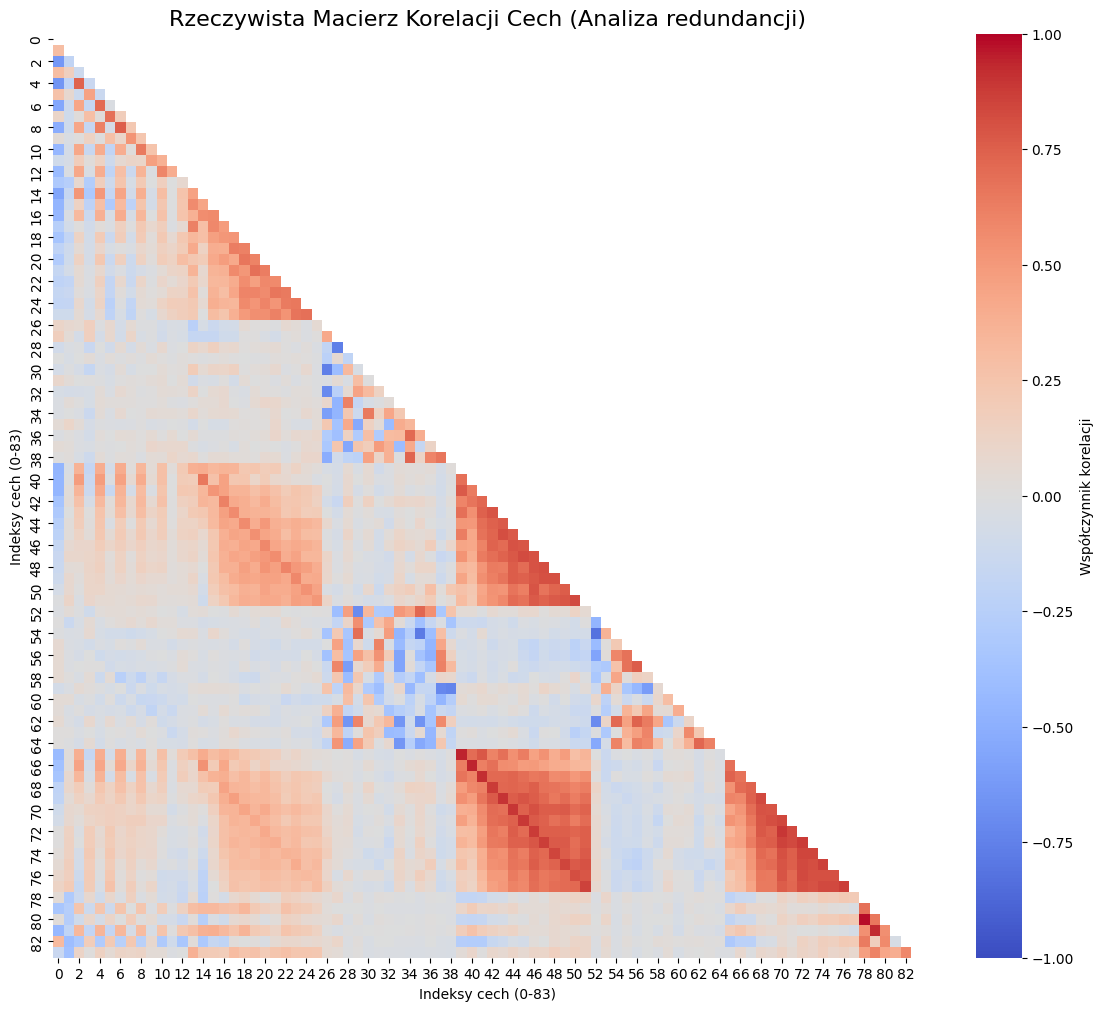

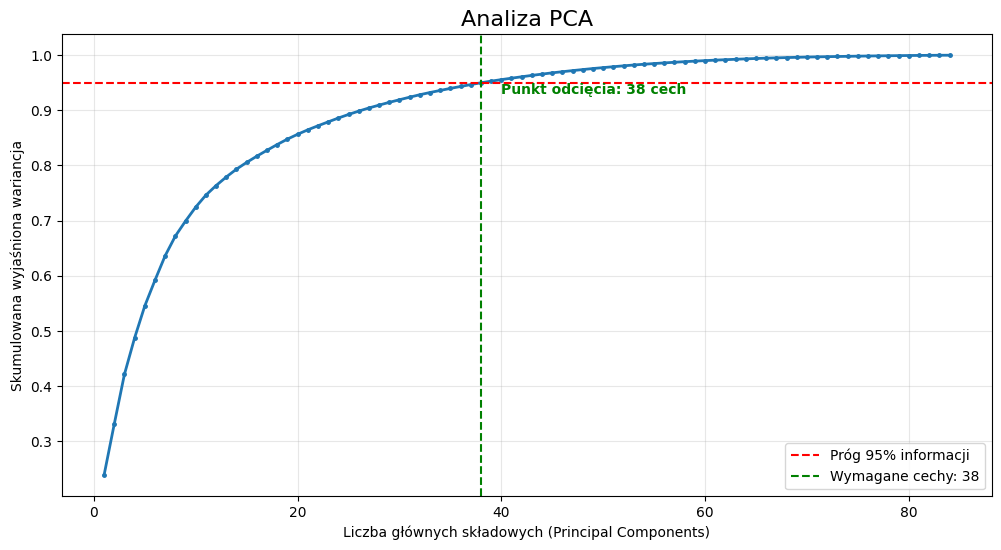

--- WNIOSKI ---
Z 84 wyekstrahowanych cech, wystarczy użyć 38, aby zachować 95% informacji.
Oznacza to redukcję wymiarowości o 54.8%.


In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# --- PRZYGOTOWANIE DANYCH RZECZYWISTYCH ---
if 'features_xs' not in locals():
    raise ValueError("Upewnij się, że uruchomiłeś komórki z ekstrakcją cech (features_xs)!")

X_real = features_xs.copy()

# Normalizacja (Z-score)
X_real = (X_real - X_real.mean(axis=0)) / (X_real.std(axis=0) + 1e-8)

# --- 1. HEATMAPA KORELACJI ---
plt.figure(figsize=(14, 12))
corr_matrix = np.corrcoef(X_real, rowvar=False)

# Maska, aby pokazać tylko dolny/górny trójkąt (macierz jest symetryczna)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, 
            cbar_kws={'label': 'Współczynnik korelacji'})

plt.title('Rzeczywista Macierz Korelacji Cech (Analiza redundancji)', fontsize=16)
plt.xlabel('Indeksy cech (0-83)')
plt.ylabel('Indeksy cech (0-83)')
plt.show()

# --- 2. PCA - WYKRES OSYPISKA (Rzeczywiste dane) ---
pca = PCA().fit(X_real)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Znalezienie liczby składowych dla progu 95%
n_95 = np.argmax(cumulative_variance >= 0.95) + 1

plt.figure(figsize=(12, 6))
# Rysujemy linię wariancji
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, linewidth=2, marker='.', markersize=5)

# Linie pomocnicze
plt.axhline(y=0.95, color='r', linestyle='--', label='Próg 95% informacji')
plt.axvline(x=n_95, color='g', linestyle='--', label=f'Wymagane cechy: {n_95}')

plt.title('Analiza PCA', fontsize=16)
plt.xlabel('Liczba głównych składowych (Principal Components)')
plt.ylabel('Skumulowana wyjaśniona wariancja')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Dodatkowy opis na wykresie
plt.text(n_95 + 2, 0.93, f'Punkt odcięcia: {n_95} cech', color='green', fontweight='bold')

plt.show()

print(f"--- WNIOSKI ---")
print(f"Z 84 wyekstrahowanych cech, wystarczy użyć {n_95}, aby zachować 95% informacji.")
print(f"Oznacza to redukcję wymiarowości o {100 - (n_95/84)*100:.1f}%.")

/tmp/ipykernel_44930/3856783691.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=feature, data=df_vis, palette="Set3")
/tmp/ipykernel_44930/3856783691.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=feature, data=df_vis, palette="Set3")
/tmp/ipykernel_44930/3856783691.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=feature, data=df_vis, palette="Set3")
/tmp/ipykernel_44930/3856783691.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.1

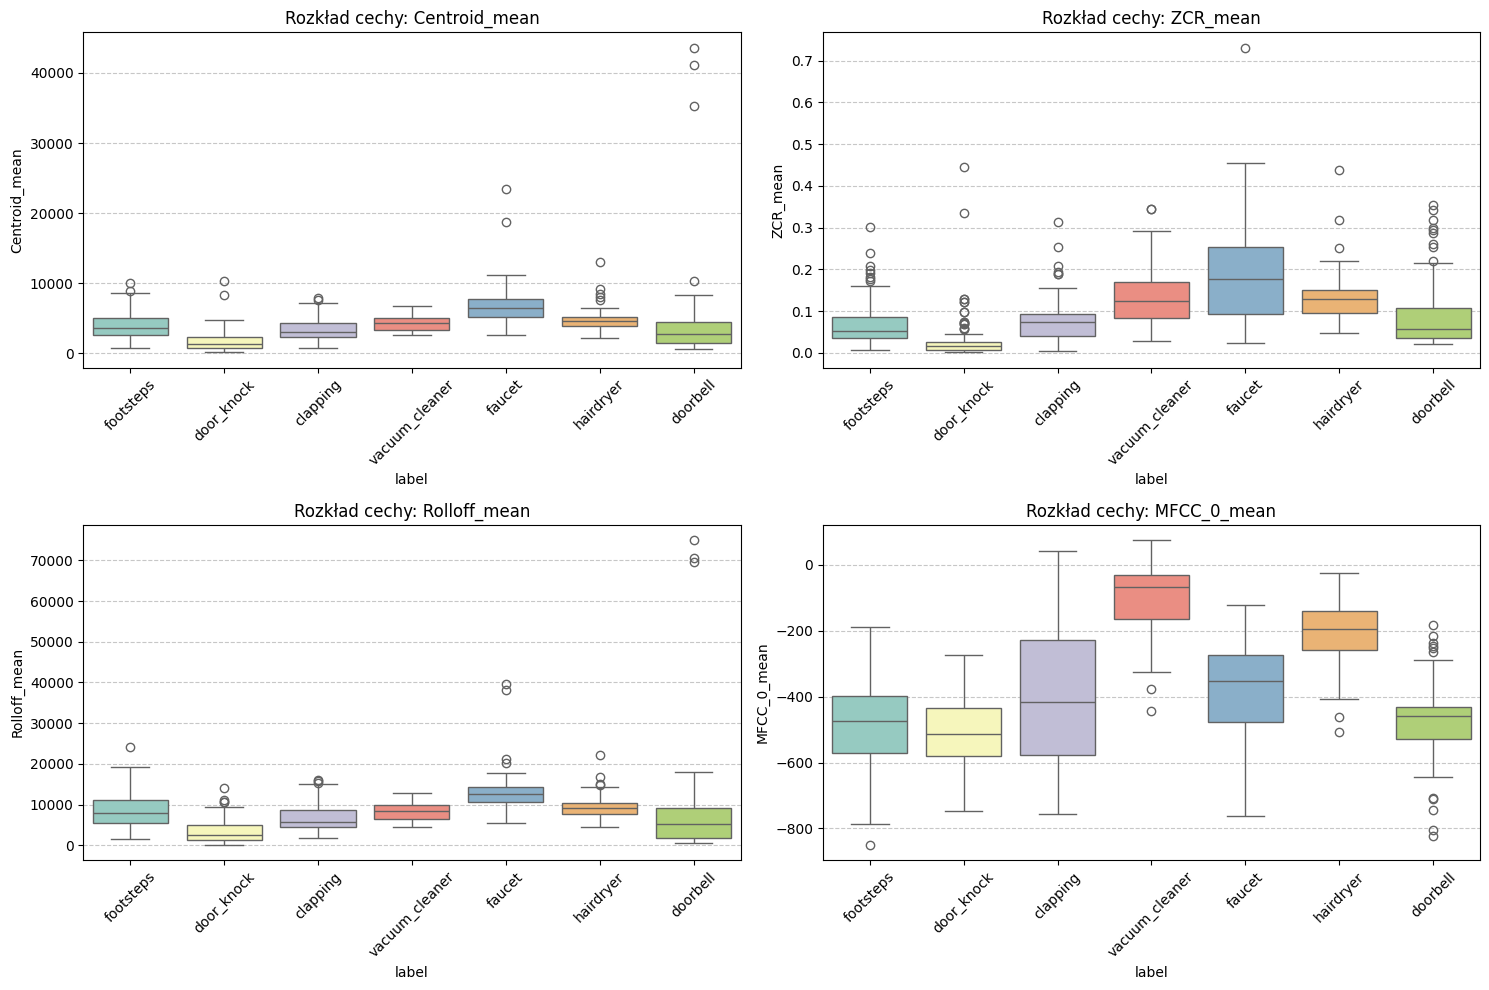

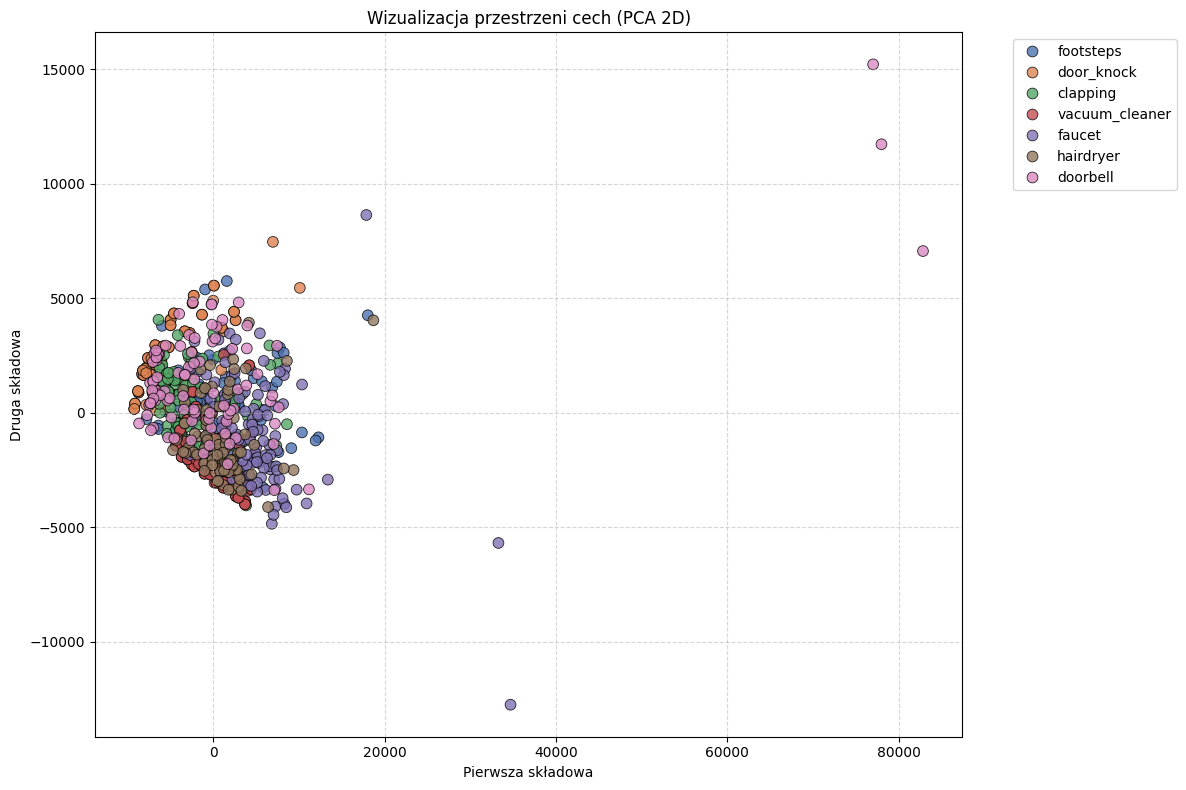

In [47]:
import pandas as pd
from sklearn.decomposition import PCA

# --- PRZYGOTOWANIE DANYCH DO WIZUALIZACJI ---

# 0-12: MFCC Mean, 13-25: MFCC Std, ..., 78: Centroid Mean, 82: ZCR Mean
feature_names = [f"MFCC_{i}_mean" for i in range(13)] + \
                [f"MFCC_{i}_std" for i in range(13)] + \
                [f"Delta_{i}_mean" for i in range(13)] + \
                [f"Delta_{i}_std" for i in range(13)] + \
                [f"Delta2_{i}_mean" for i in range(13)] + \
                [f"Delta2_{i}_std" for i in range(13)] + \
                ["Centroid_mean", "Centroid_std", 
                 "Rolloff_mean", "Rolloff_std", 
                 "ZCR_mean", "ZCR_std"]

df_vis = pd.DataFrame(features_xs, columns=feature_names)
df_vis['label'] = labels_ys

# --- 1. WYKRESY PUDEŁKOWE (BOXPLOTS) ---
selected_features = ['Centroid_mean', 'ZCR_mean', 'Rolloff_mean', 'MFCC_0_mean']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='label', y=feature, data=df_vis, palette="Set3")
    plt.title(f'Rozkład cechy: {feature}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# --- 2. WYKRES PUNKTOWY (SCATTER PLOT) Z PCA ---
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_xs)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=features_pca[:, 0], 
    y=features_pca[:, 1], 
    hue=labels_ys, 
    palette="deep", 
    s=60, 
    alpha=0.8,
    edgecolor="k"
)
plt.title('Wizualizacja przestrzeni cech (PCA 2D)')
plt.xlabel(f'Pierwsza składowa')
plt.ylabel(f'Druga składowa')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/tmp/ipykernel_44930/377055939.py:40: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


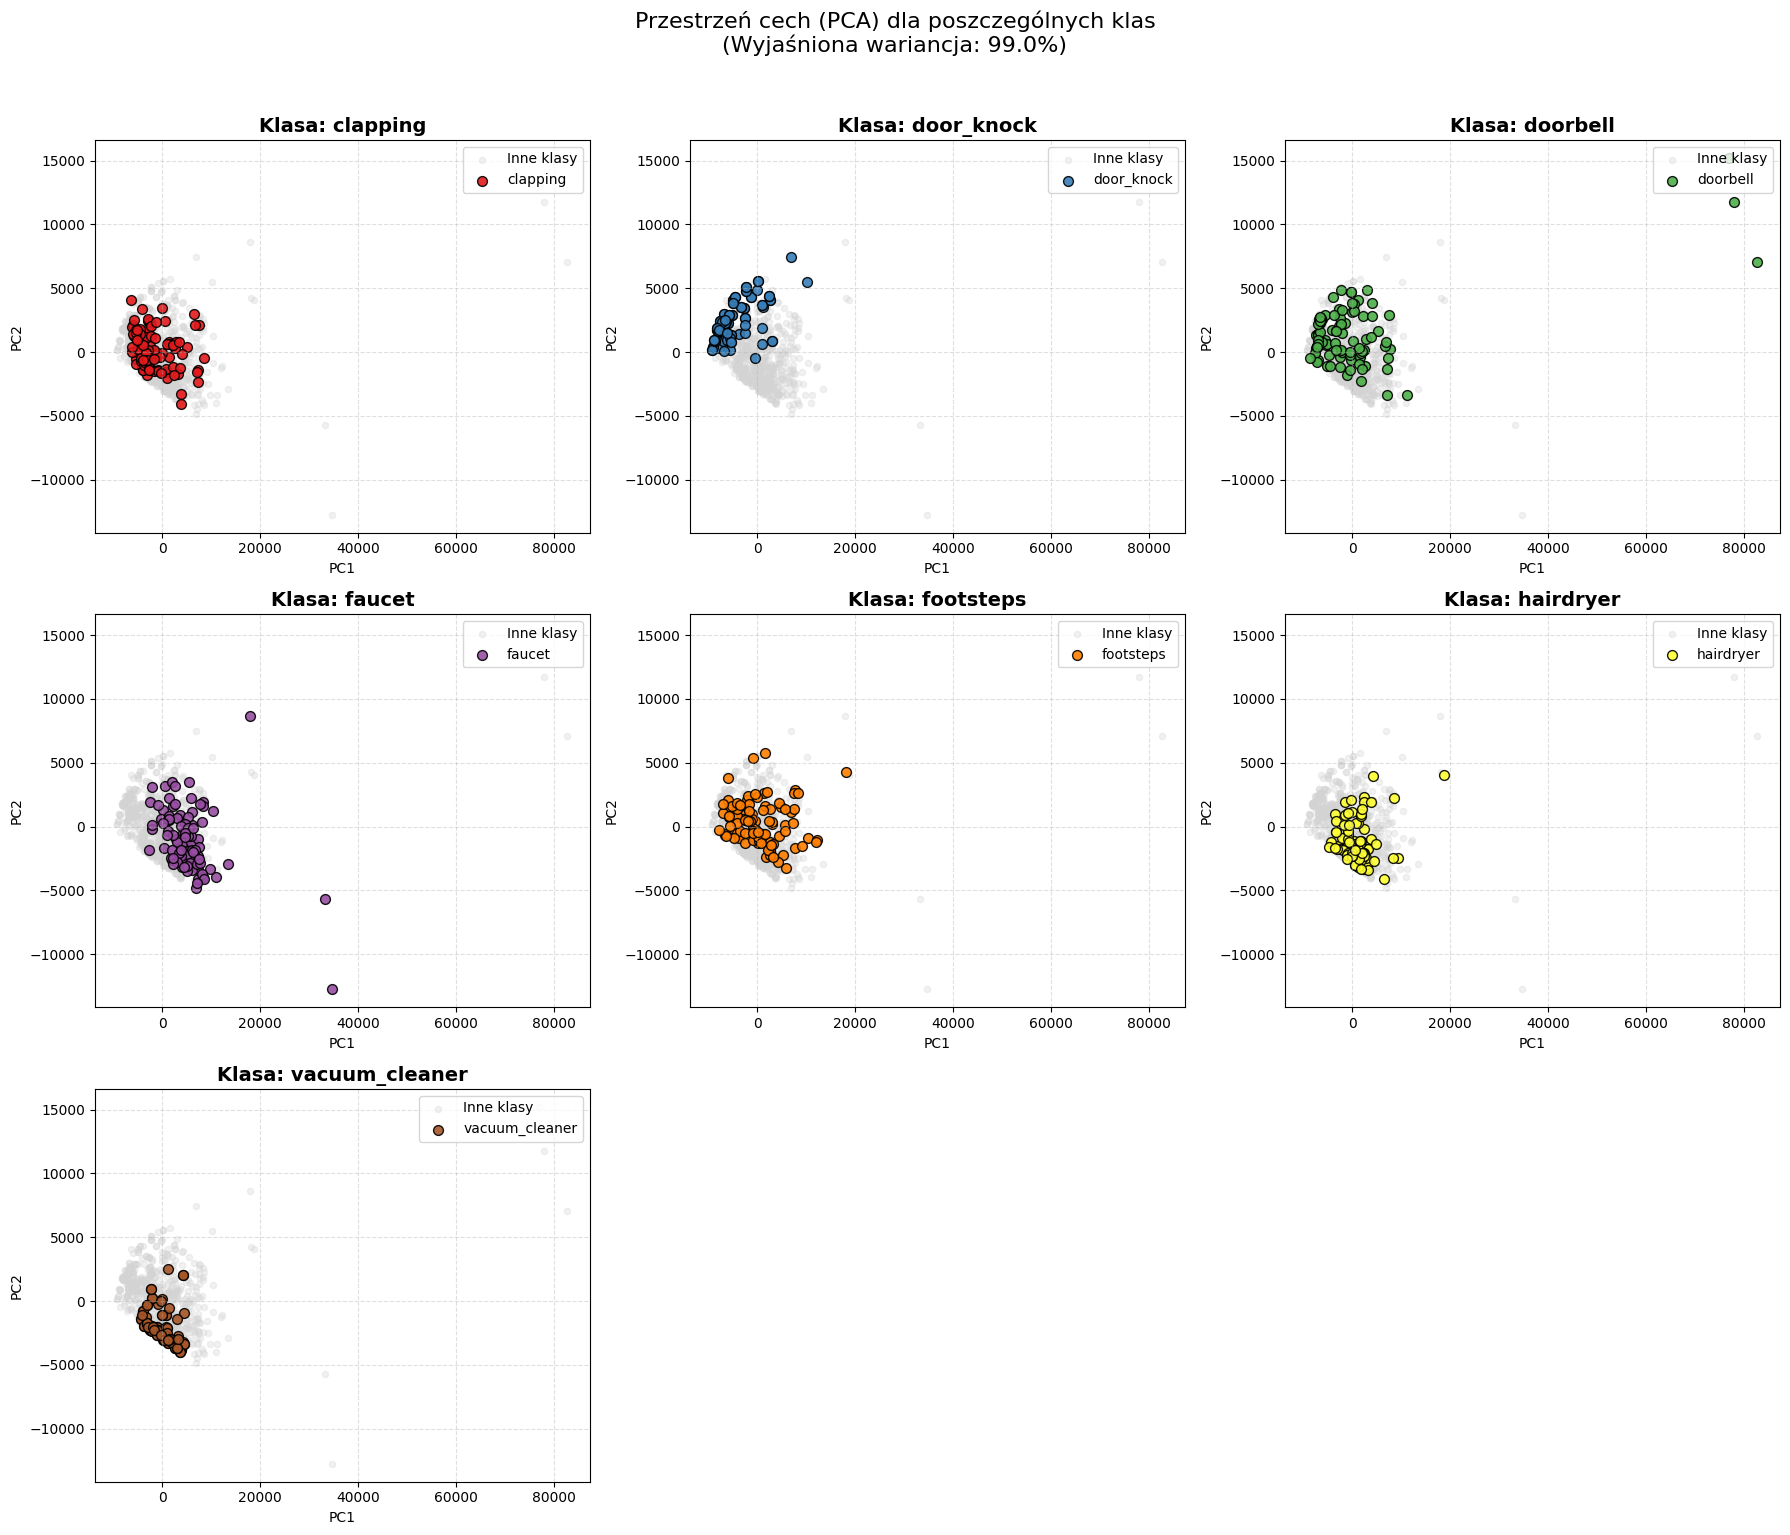

In [48]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# --- PRZYGOTOWANIE DANYCH ---
X_vis = np.array(features_xs)
y_vis = np.array(labels_ys)
unique_classes = np.unique(y_vis)

# --- PCA (Redukcja do 2D) ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_vis)

# --- KONFIGURACJA SIATKI WYKRESÓW ---
n_classes = len(unique_classes)
n_cols = 3 
n_rows = math.ceil(n_classes / n_cols)

plt.figure(figsize=(6 * n_cols, 5 * n_rows))
plt.suptitle(f'Przestrzeń cech (PCA) dla poszczególnych klas\n(Wyjaśniona wariancja: {sum(pca.explained_variance_ratio_):.1%})', fontsize=16, y=1.02)

for i, cls in enumerate(unique_classes):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    
    # 1. Rysujemy tło (wszystkie inne klasy na szaro)
    other_mask = (y_vis != cls)
    ax.scatter(
        X_pca[other_mask, 0], 
        X_pca[other_mask, 1], 
        c='lightgray', 
        alpha=0.3, 
        s=20, 
        label='Inne klasy'
    )
    
    # 2. Rysujemy aktualną klasę (na kolorowo i wyraźniej)
    cls_mask = (y_vis == cls)
    ax.scatter(
        X_pca[cls_mask, 0], 
        X_pca[cls_mask, 1], 
        c=sns.color_palette("Set1", n_colors=n_classes)[i],
        alpha=0.9, 
        s=50, 
        edgecolor='k',
        label=cls
    )
    
    ax.set_title(f'Klasa: {cls}', fontsize=14, fontweight='bold')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.legend(loc='upper right')
    ax.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

Rozpoczynam dobór hiperparametrów (może to chwilę potrwać)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth


Najlepsze parametry: {'svc__C': 10, 'svc__gamma': 'scale'}
Najlepsza dokładność (Cross-Validation): 82.83%

Top 5 kombinacji parametrów:
    param_svc__C param_svc__gamma  mean_test_score  std_test_score
12         100.0            scale         0.828323        0.044601
13         100.0             auto         0.828323        0.044601
9           10.0             auto         0.828323        0.038477
8           10.0            scale         0.828323        0.038477
11          10.0             0.01         0.826173        0.036903
Rozpoczynam walidację krzyżową...
Wyniki CV (5-fold): [0.82978723 0.78494624 0.78494624 0.87096774 0.87096774]
Średnia dokładność (CV): 82.83% (+/- 3.85%)

Dokładność na zbiorze testowym (Hold-out): 80.34%


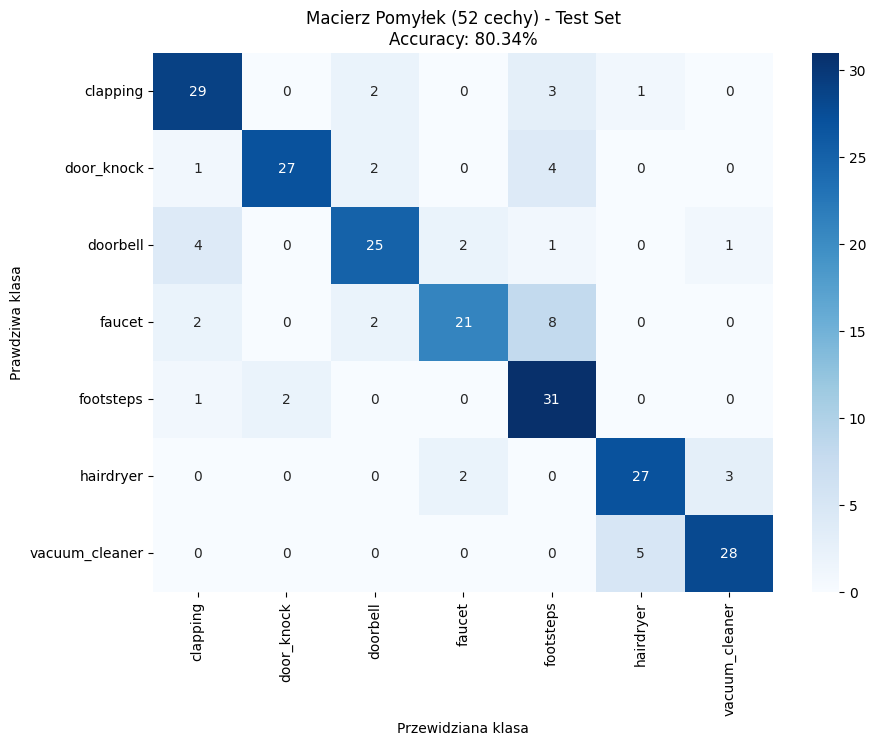

In [49]:
# --- PRZYGOTOWANIE DANYCH I TRENING (PIPELINE) ---

# 1. Encodowanie etykiet
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(labels_ys)

# 2. Podział na zbiór treningowy i testowy
x_train, x_test, y_train, y_test = train_test_split(
    features_xs, y_enc, test_size=1/3, random_state=42, stratify=y_enc
)

# 3. Tworzymy Pipeline: Skalowanie + SVM
from sklearn.model_selection import GridSearchCV

# --- 3. STROJENIE HIPERPARAMETRÓW (GRID SEARCH) ---

base_pipeline = make_pipeline(
    StandardScaler(), 
    SVC(kernel="rbf", probability=True, random_state=42)
)


param_grid = {
    'svc__C': [0.1, 1, 10, 100],            
    'svc__gamma': ['scale', 'auto', 0.1, 0.01]
}

# Konfigurujemy GridSearch
grid_search = GridSearchCV(
    base_pipeline,      
    param_grid,        
    cv=5,               
    scoring='accuracy', 
    n_jobs=-1,          
    verbose=1           
)

print("Rozpoczynam dobór hiperparametrów (może to chwilę potrwać)...")
grid_search.fit(x_train, y_train)

# --- WYNIKI STROJENIA ---
print(f"\nNajlepsze parametry: {grid_search.best_params_}")
print(f"Najlepsza dokładność (Cross-Validation): {grid_search.best_score_:.2%}")

# --- TABELA WYNIKÓW (DLA DOKUMENTACJI) ---
results_df = pd.DataFrame(grid_search.cv_results_)
print("\nTop 5 kombinacji parametrów:")
print(results_df[['param_svc__C', 'param_svc__gamma', 'mean_test_score', 'std_test_score']]
      .sort_values(by='mean_test_score', ascending=False)
      .head(5))

# --- PODMIANA MODELU ---
clf_pipeline = grid_search.best_estimator_

# 4. Trening i Walidacja Krzyżowa (5-fold) na zbiorze treningowym
print("Rozpoczynam walidację krzyżową...")
cv_scores = cross_val_score(clf_pipeline, x_train, y_train, cv=5, scoring='accuracy')

print(f"Wyniki CV (5-fold): {cv_scores}")
print(f"Średnia dokładność (CV): {cv_scores.mean():.2%} (+/- {cv_scores.std():.2%})")

# 5. Finalny trening na całym zbiorze treningowym
clf_pipeline.fit(x_train, y_train)

# 6. Sprawdzenie na zbiorze testowym (ostateczna weryfikacja)
y_pred = clf_pipeline.predict(x_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"\nDokładność na zbiorze testowym (Hold-out): {test_acc:.2%}")

# --- WIZUALIZACJA MACIERZY POMYŁEK ---
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title(f"Macierz Pomyłek (52 cechy) - Test Set\nAccuracy: {test_acc:.2%}")
plt.ylabel("Prawdziwa klasa")
plt.xlabel("Przewidziana klasa")
plt.show()

## Klasyfikator SVM

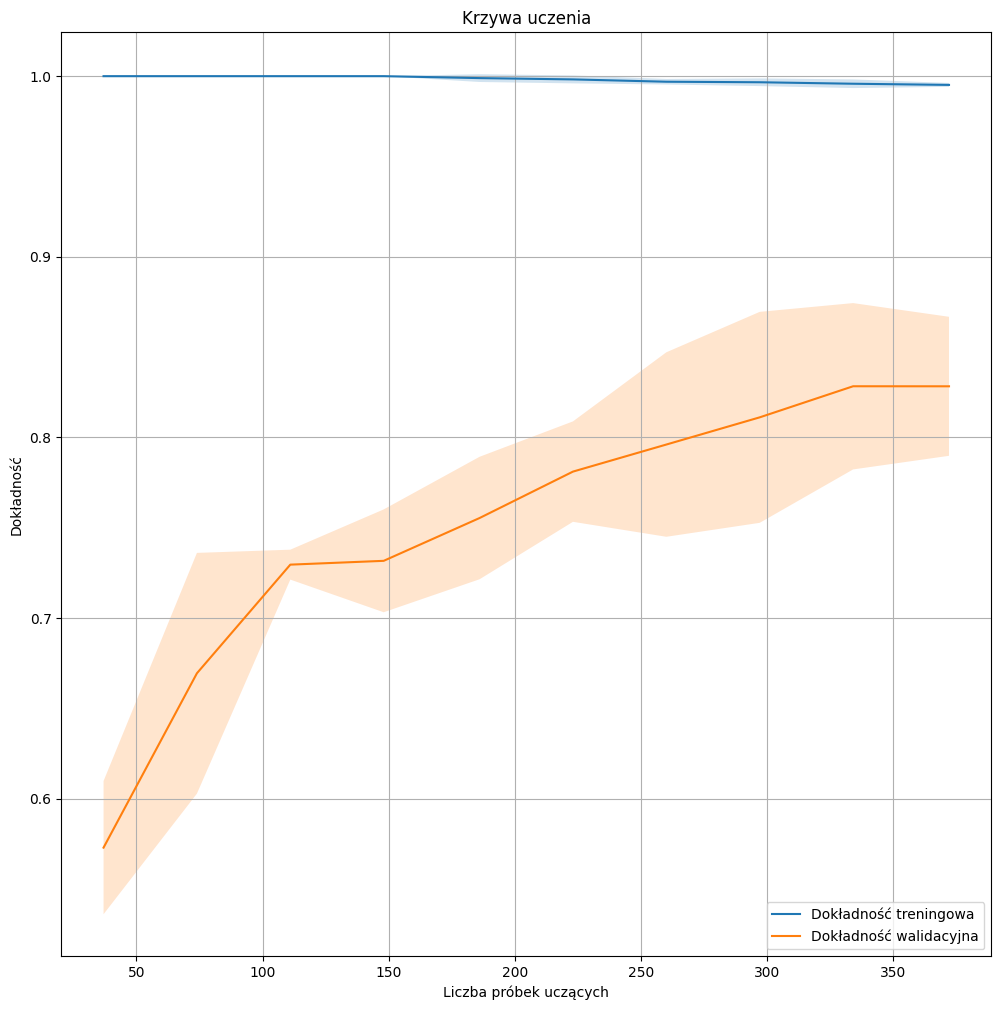

In [50]:
train_sizes, train_scores, val_scores = learning_curve(
    estimator=clf_pipeline,
    X=x_train,
    y=y_train,
    cv=5,
    train_sizes=numpy.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = numpy.mean(train_scores, axis=1)
train_std = numpy.std(train_scores, axis=1)
val_mean = numpy.mean(val_scores, axis=1)
val_std = numpy.std(val_scores, axis=1)

plt.figure(figsize=(12, 12))
plt.plot(train_sizes, train_mean, label="Dokładność treningowa")
plt.plot(train_sizes, val_mean, label="Dokładność walidacyjna")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.title("Krzywa uczenia")
plt.xlabel("Liczba próbek uczących")
plt.ylabel("Dokładność")
plt.legend()
plt.grid(True)
plt.show()

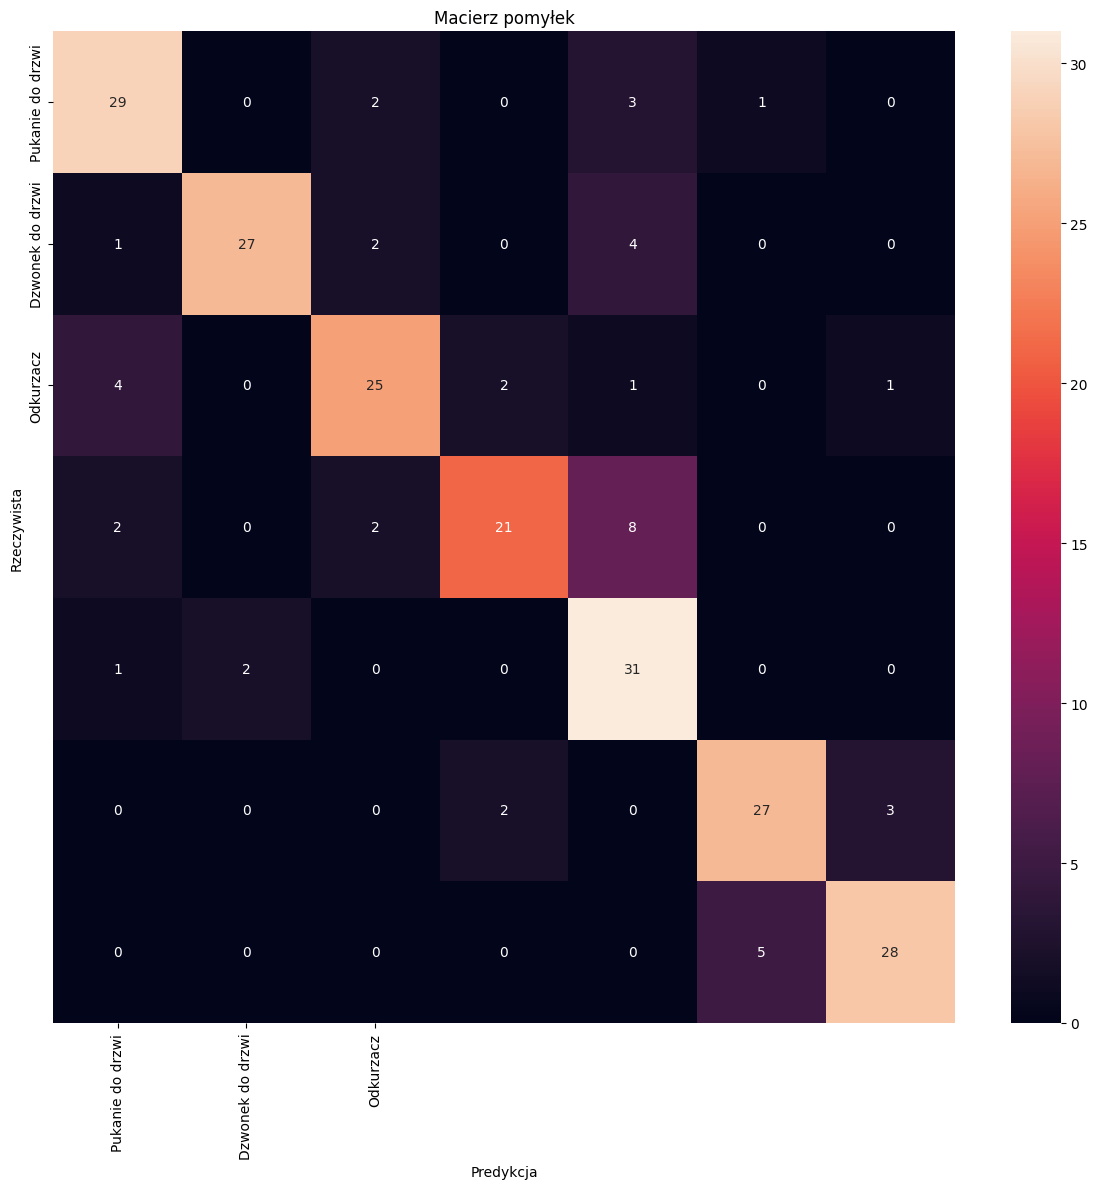

In [51]:
plt.figure(figsize=(12, 12))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt="d",
    xticklabels=["Pukanie do drzwi", "Dzwonek do drzwi", "Odkurzacz"],
    yticklabels=["Pukanie do drzwi", "Dzwonek do drzwi", "Odkurzacz"],
)

plt.xlabel("Predykcja")
plt.ylabel("Rzeczywista")
plt.title("Macierz pomyłek")
plt.tight_layout()
plt.show()

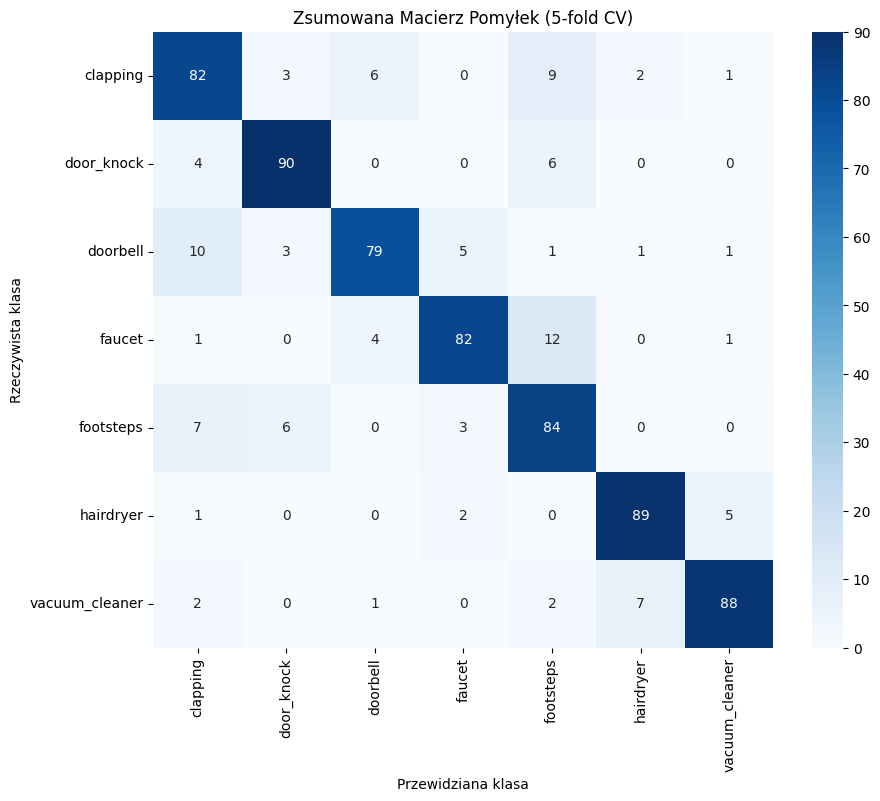

In [52]:
# 1. Definiujemy brakujące zmienne (K-Fold)
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# 2. Generujemy predykcje dla całego zbioru danych przy użyciu CV
y_pred_cv = cross_val_predict(clf_pipeline, features_xs, y_enc, cv=skf)

# 3. Wizualizacja Macierzy Pomyłek
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_enc, y_pred_cv)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)

plt.xlabel("Przewidziana klasa")
plt.ylabel("Rzeczywista klasa")
plt.title(f"Zsumowana Macierz Pomyłek ({k_folds}-fold CV)")
plt.show()

 Ładowanie modelu VGGish z TensorFlow Hub...
Model VGGish gotowy.

 Szukam danych w: /home/muzykos/Documents/Github/Projekt_badawczy_System_rozpoznawania_zdarzen_dzwiekowych_w_przestrzeni_domowej/dataset
Znalezione klasy: ['footsteps', 'door_knock', 'clapping', 'vacuum_cleaner', 'faucet', 'hairdryer', 'doorbell']
   -> Przetwarzanie 'footsteps': 100 plików...
 Błąd inferencji przy pliku footsteps_003.wav: Graph execution error:

Detected at node StatefulPartitionedCall/StatefulPartitionedCall/vggish/conv2/Relu defined at (most recent call last):
<stack traces unavailable>
input depth must be evenly divisible by filter depth: 1 vs 64
	 [[{{node StatefulPartitionedCall/StatefulPartitionedCall/vggish/conv2/Relu}}]] [Op:__inference_restored_function_body_80616]
 Błąd inferencji przy pliku footsteps_096.wav: Graph execution error:

Detected at node StatefulPartitionedCall/StatefulPartitionedCall/vggish/conv2/Relu defined at (most recent call last):
<stack traces unavailable>
input depth mus

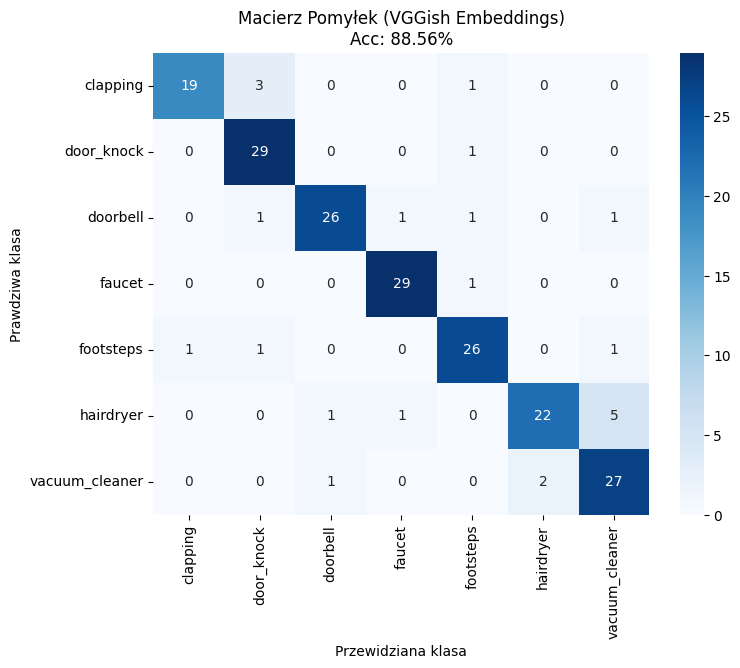


 Generowanie krzywej uczenia...


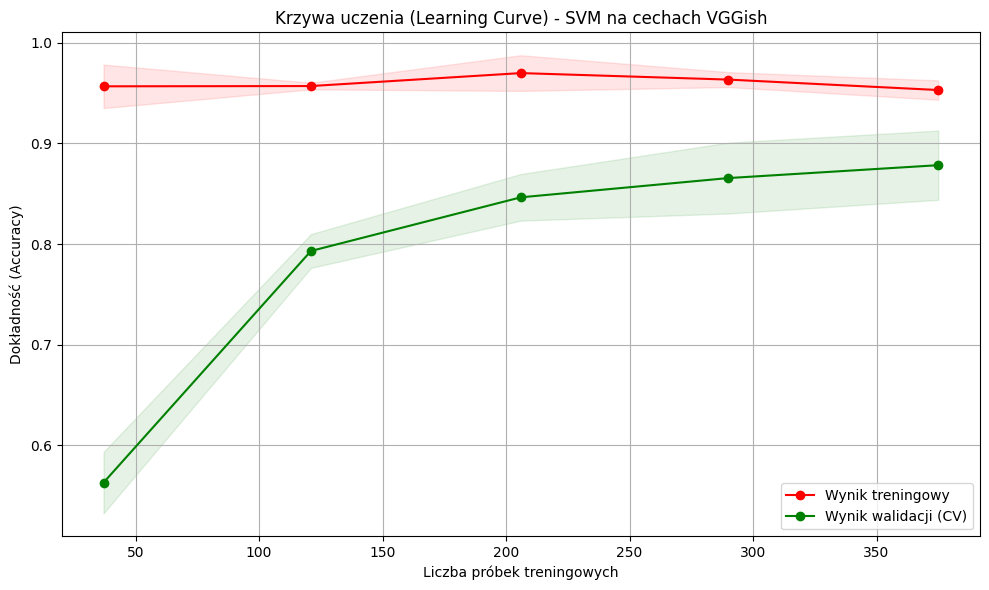

In [55]:
import os
import numpy as np
import librosa
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

# 1. KONFIGURACJA I ŁADOWANIE MODELU AI

SR_VGG = 16000
VGGISH_MODEL_URL = "https://tfhub.dev/google/vggish/1"

print(" Ładowanie modelu VGGish z TensorFlow Hub...")
vggish_model = hub.load(VGGISH_MODEL_URL)
print("Model VGGish gotowy.")

def load_audio_for_vggish(file_path):
    """
    Wczytuje audio i resampluje do 16kHz (wymóg VGGish).
    Zwraca surowy sygnał (waveform).
    """
    try:
        y, sr = librosa.load(file_path, sr=SR_VGG)
        if len(y.shape) > 1:
            y = np.mean(y, axis=1)
        if np.max(np.abs(y)) > 0:
            y = y / np.max(np.abs(y))
        return y
    except Exception as e:
        print(f"Błąd ładowania {file_path}: {e}")
        return None

# 2. ŁADOWANIE DANYCH

DATA_DIR = '../../dataset/' 

vgg_features = []
labels = []

print(f"\n Szukam danych w: {os.path.abspath(DATA_DIR)}")

if not os.path.exists(DATA_DIR):
    print(f" BŁĄD: Katalog '{DATA_DIR}' nie istnieje.")
else:
    classes = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
    print(f"Znalezione klasy: {classes}")

    for label in classes:
        class_dir = os.path.join(DATA_DIR, label)
        file_list = [f for f in os.listdir(class_dir) if f.lower().endswith('.wav')]
        
        print(f"   -> Przetwarzanie '{label}': {len(file_list)} plików...")
        
        for filename in file_list:
            file_path = os.path.join(class_dir, filename)
            waveform = load_audio_for_vggish(file_path)
            
            if waveform is not None and len(waveform) > 0:
                try:
                    embeddings = vggish_model(waveform)
                    if tf.shape(embeddings)[0] > 0:
                        file_embedding = np.mean(embeddings.numpy(), axis=0)
                        vgg_features.append(file_embedding)
                        labels.append(label)
                    else:
                        print(f" Plik {filename} jest za krótki (<1s).")
                except Exception as e:
                    print(f" Błąd inferencji przy pliku {filename}: {e}")

    X = np.array(vgg_features)
    y_labels = np.array(labels)

    print(f"\n Zakończono! Wymiary macierzy cech: {X.shape}")

# 3. TRENING I OCENA (Klasyfikator SVM)

if len(X) > 0:
    le = LabelEncoder()
    y_enc = le.fit_transform(y_labels)

    # Podział danych
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_enc, test_size=0.3, random_state=42, stratify=y_enc
    )

    # Pipeline
    clf = make_pipeline(
        StandardScaler(),
        SVC(kernel='rbf', probability=True, random_state=42)
    )

    print("\n Trenowanie klasyfikatora SVM...")
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"\n WYNIK PODEJŚCIA 'AI' (VGGish + SVM):")
    print(f"Dokładność (Accuracy): {acc:.2%}")

    # Wykres 1: Macierz Pomyłek
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Macierz Pomyłek (VGGish Embeddings)\nAcc: {acc:.2%}')
    plt.ylabel('Prawdziwa klasa')
    plt.xlabel('Przewidziana klasa')
    plt.show()

    # 4. KRZYWA UCZENIA (Learning Curve)
    print("\n Generowanie krzywej uczenia...")

    # Obliczamy krzywą uczenia na zbiorze treningowym (z walidacją krzyżową cv=5)
    train_sizes, train_scores, val_scores = learning_curve(
        clf, X_train, y_train, 
        cv=5, 
        n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 5),
        scoring='accuracy'
    )

    # Obliczanie średnich i odchyleń standardowych
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    # Wykres 2: Krzywa Uczenia
    plt.figure(figsize=(10, 6))
    plt.title("Krzywa uczenia (Learning Curve) - SVM na cechach VGGish")
    plt.xlabel("Liczba próbek treningowych")
    plt.ylabel("Dokładność (Accuracy)")
    plt.grid()

    # Zakres błędu (odchylenie standardowe)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.1, color="g")

    # Linie średnich wyników
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Wynik treningowy")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Wynik walidacji (CV)")

    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

else:
    print(" Nie udało się stworzyć zbioru danych. Sprawdź ścieżki.")

 Ładowanie modelu VGGish...
 Model gotowy.
 Znalezione klasy: ['footsteps', 'door_knock', 'clapping', 'vacuum_cleaner', 'faucet', 'hairdryer', 'doorbell']
   -> footsteps: 100 plików
   -> door_knock: 100 plików
   -> clapping: 103 plików
   -> vacuum_cleaner: 100 plików
   -> faucet: 100 plików
   -> hairdryer: 97 plików
   -> doorbell: 100 plików

 Dane gotowe: (700, 128)

 [1/2] Trenowanie SVM...
   -> SVM Accuracy: 90.95%

 [2/2] Trenowanie Sieci Neuronowej...


/home/muzykos/Documents/Github/Projekt_badawczy_System_rozpoznawania_zdarzen_dzwiekowych_w_przestrzeni_domowej/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
   -> Neural Net Accuracy: 90.95%


/tmp/ipykernel_44930/4270048351.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results, x='Model', y='Dokładność', palette='viridis')


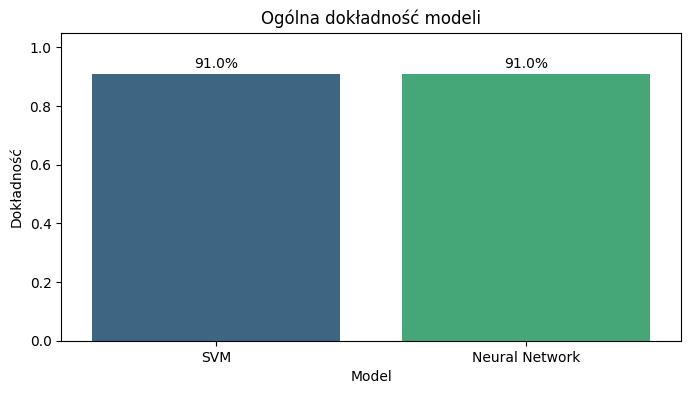

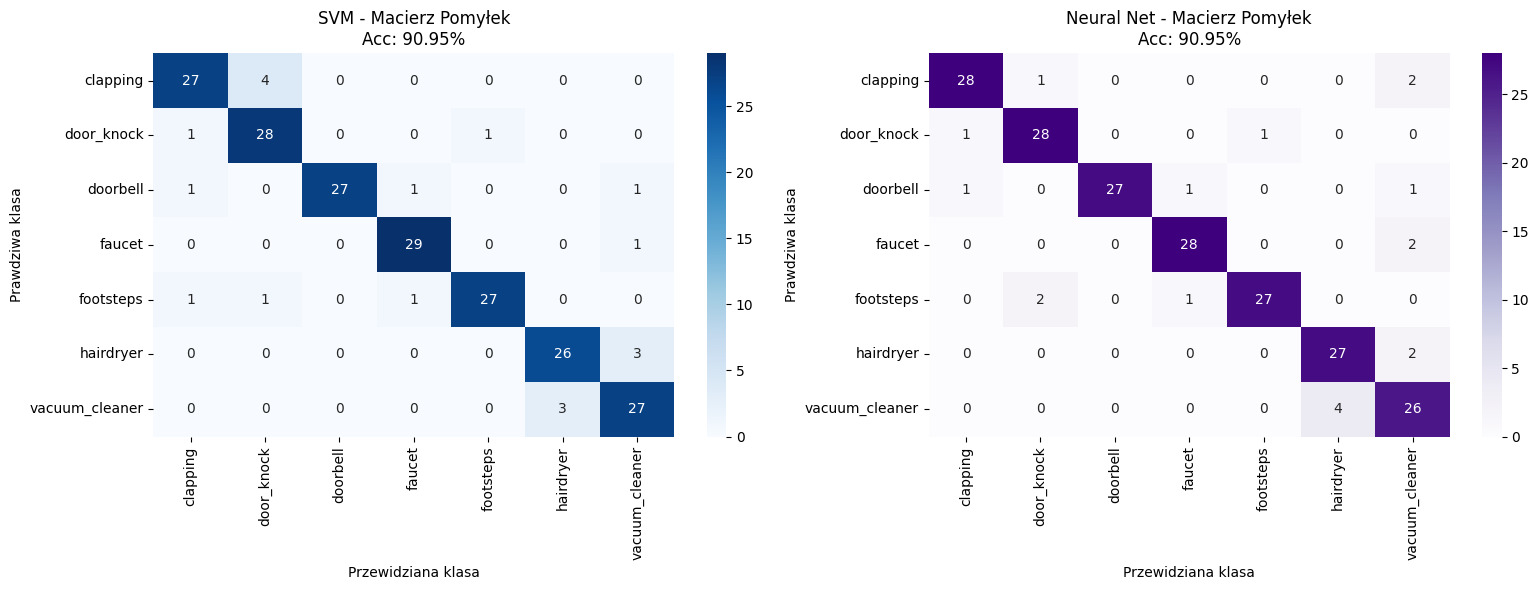

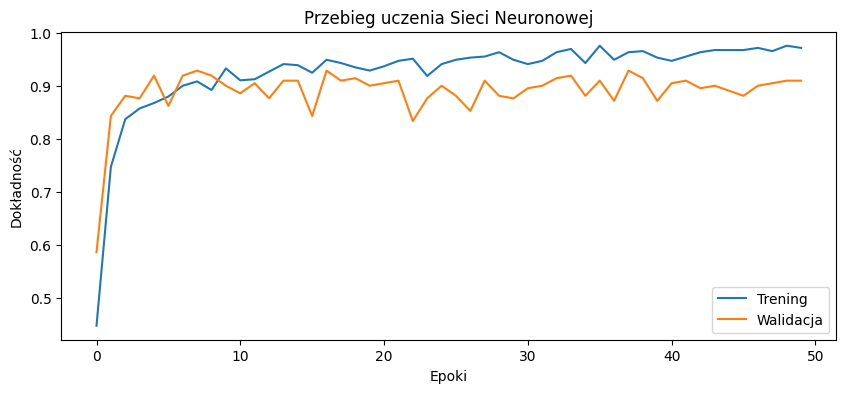

In [54]:
import os
import numpy as np
import librosa
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Biblioteki do Sieci Neuronowej
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# 1. ŁADOWANIE VGGish
SR_VGG = 16000
VGGISH_MODEL_URL = "https://tfhub.dev/google/vggish/1"

print(" Ładowanie modelu VGGish...")
vggish_model = hub.load(VGGISH_MODEL_URL)
print(" Model gotowy.")

def load_audio_for_vggish(file_path):
    """
    Wczytuje audio, resampluje do 16kHz i zapewnia minimalną długość.
    Zwraca tensor gotowy dla modelu VGGish.
    """
    try:
        y, sr = librosa.load(file_path, sr=SR_VGG)
        
        if len(y.shape) > 1:
            y = np.mean(y, axis=1)
            
        if np.max(np.abs(y)) > 0:
            y = y / np.max(np.abs(y))
            

        min_samples = SR_VGG  
        if len(y) < min_samples:
            pad_length = min_samples - len(y)
            y = np.pad(y, (0, pad_length), mode='constant')
            
        return tf.convert_to_tensor(y, dtype=tf.float32)

    except Exception as e:
        print(f" Błąd ładowania {file_path}: {e}")
        return None

# 2. PRZETWARZANIE DANYCH
DATA_DIR = '../../dataset/' 
vgg_features = []
labels = []

if os.path.exists(DATA_DIR):
    classes = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
    print(f" Znalezione klasy: {classes}")

    for label in classes:
        class_dir = os.path.join(DATA_DIR, label)
        file_list = [f for f in os.listdir(class_dir) if f.lower().endswith('.wav')]
        print(f"   -> {label}: {len(file_list)} plików")
        
        for filename in file_list:
            waveform = load_audio_for_vggish(os.path.join(class_dir, filename))
            if waveform is not None:
                # VGGish inference
                embeddings = vggish_model(waveform)
                if tf.shape(embeddings)[0] > 0:
                    vgg_features.append(np.mean(embeddings.numpy(), axis=0))
                    labels.append(label)

    X = np.array(vgg_features)
    y_labels = np.array(labels)
    print(f"\n Dane gotowe: {X.shape}")
else:
    print(" Błąd: Nie znaleziono folderu dataset.")
    X = []

# 3. TRENING I OCENA
if len(X) > 0:
    # Przygotowanie etykiet
    le = LabelEncoder()
    y_enc = le.fit_transform(y_labels)
    num_classes = len(le.classes_)
    
    # Podział danych
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_enc, test_size=0.3, random_state=42, stratify=y_enc
    )

    # --- MODEL 1: SVM ---
    print("\n [1/2] Trenowanie SVM...")
    svm_clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=True))
    svm_clf.fit(X_train, y_train)
    
    y_pred_svm = svm_clf.predict(X_test)
    svm_acc = accuracy_score(y_test, y_pred_svm)
    print(f"   -> SVM Accuracy: {svm_acc:.2%}")

    # --- MODEL 2: Sieć Neuronowa ---
    print("\n [2/2] Trenowanie Sieci Neuronowej...")
    y_train_cat = to_categorical(y_train, num_classes)
    y_test_cat = to_categorical(y_test, num_classes)

    model = Sequential([
        Dense(256, activation='relu', input_shape=(128,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train_cat, epochs=50, batch_size=16, verbose=0, validation_data=(X_test, y_test_cat))
    
    # Predykcja dla sieci (potrzebna do macierzy)
    y_probs_nn = model.predict(X_test)
    y_pred_nn = np.argmax(y_probs_nn, axis=1)
    
    loss, nn_acc = model.evaluate(X_test, y_test_cat, verbose=0)
    print(f"   -> Neural Net Accuracy: {nn_acc:.2%}")

    # 4. WIZUALIZACJA WYNIKÓW I MACIERZE POMYŁEK
    
    # Porównanie dokładności (Barplot)
    plt.figure(figsize=(8, 4))
    results = pd.DataFrame({
        'Model': ['SVM', 'Neural Network'],
        'Dokładność': [svm_acc, nn_acc]
    })
    sns.barplot(data=results, x='Model', y='Dokładność', palette='viridis')
    plt.title("Ogólna dokładność modeli")
    plt.ylim(0, 1.05)
    for index, row in results.iterrows():
        plt.text(index, row.Dokładność + 0.02, f'{row.Dokładność:.1%}', color='black', ha="center")
    plt.show()

    #MACIERZE POMYŁEK (Confusion Matrices) - Obok siebie
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Macierz SVM
    sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[0])
    axes[0].set_title(f'SVM - Macierz Pomyłek\nAcc: {svm_acc:.2%}')
    axes[0].set_xlabel('Przewidziana klasa')
    axes[0].set_ylabel('Prawdziwa klasa')

    # Macierz Sieci Neuronowej
    sns.heatmap(confusion_matrix(y_test, y_pred_nn), annot=True, fmt='d', cmap='Purples',
                xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[1])
    axes[1].set_title(f'Neural Net - Macierz Pomyłek\nAcc: {nn_acc:.2%}')
    axes[1].set_xlabel('Przewidziana klasa')
    axes[1].set_ylabel('Prawdziwa klasa')

    plt.tight_layout()
    plt.show()

    # Wykres uczenia sieci
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['accuracy'], label='Trening')
    plt.plot(history.history['val_accuracy'], label='Walidacja')
    plt.title('Przebieg uczenia Sieci Neuronowej')
    plt.xlabel('Epoki')
    plt.ylabel('Dokładność')
    plt.legend()
    plt.show()

else:
    print("Brak danych do analizy.")